# Modeling

### Imports

In [14]:
#standard imports
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# Evaluation Functions

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            plot_confusion_matrix, f1_score, cohen_kappa_score,\
                            roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

#evaluation functions
def model_evaluation(model, X_tr, y_tr, X_te, y_te, labels): 
    '''
    Evaluates model and returns scores cross-val-score, accuracy, precision, recall, f1, and cohen-kappa,  
    then plots a confusion matrix and ROC-AUC graph. 
    
    'code from https://inblog.in/AUC-ROC-score-and-curve-in-multiclass-classification-problems-2ja4jOHb2X'
    
    Inputs: 
        model: model fitted to X_tr
        X_tr: Training variable
        y_tr: Training target
        X_te: Test variable
        y_te: Test target
        labels: target labeles for confusion matrix
        
    '''
    #determine multiclass or binary model
    classes = len(labels)
       
    #predictions
    preds = model.predict(X_te)
    preds_proba = model.predict_proba(X_te)

    #adjustments for binary vs. multi-class evluations
    if classes == 2:
        average = None
        roc_auc = roc_auc_score(y_te, preds_proba)
    else: 
        average = 'macro'
        roc_auc = roc_auc_score(y_te, preds_proba, multi_class='ovo', average='weighted')

    #score model from metrics
    avg_cros_val = cross_val_score(model, X_tr, y_tr, cv=3).mean()
    accuracy = accuracy_score(y_te, preds)
    precision = precision_score(y_te, preds, average=average)
    recall = recall_score(y_te, preds, average=average)
    f1 = f1_score(y_te, preds, average=average)
    cohen_kappa = cohen_kappa_score(y_te, preds)
    
    #store scores
    scores = [[model, avg_cros_val, accuracy, precision, recall, f1, cohen_kappa, roc_auc]]
    scores_df = pd.DataFrame(scores, columns=['model', 'cross_val', 'accuracy','precision','recall','f1','cohen-kappa', 'roc-auc'])

    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}

    for i in range(classes):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_te, preds_proba[:,i], pos_label=i)

    #plot evaluation graphs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

    ConfusionMatrixDisplay.from_predictions(y_te, preds, display_labels=le.classes_, ax=ax1, normalize='true')
    ax1.set_title('Confusion Matrix')

    for i in range(len(le.classes_)):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_te, preds_proba[:,i], pos_label=i)

        #plot binary roc-auc
    if classes == 2: 
        ax2.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=str(le.inverse_transform([0])))
        ax2.plot(fpr[1], tpr[1], linestyle='--',color='green', label=str(le.inverse_transform([1])))
    
    #plot mulit-class roc
    else: 
        ax2.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=str(le.inverse_transform([0])))
        ax2.plot(fpr[1], tpr[1], linestyle='--',color='green', label=str(le.inverse_transform([1])))
        ax2.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=str(le.inverse_transform([2])))

    # plotting
    ax2.plot([0,1], [0,1], linestyle='--', color='grey')    
    ax2.set_title('ROC curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive rate')
    ax2.legend(loc='best')

    plt.show();

    return scores_df

In [3]:
#load data
data = pd.read_csv('../data/data.csv', index_col=0)
data.head(1)

,text,target
0,welcome team thanks joining team name kathleen...,Liberal


# Train Test Split
* Conduct train, test, validation split early to prevent leakage
* Stratify target within test and validation sets to account for imbalance

In [4]:
X = data['text'].astype(str)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.35, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size = 0.2, stratify=y_test)

print('Sizes: ')
print('X_train: ', {X_train.shape})
print('X_test: ', {X_test.shape})
print('X_val: ', {X_val.shape})

Sizes: 
X_train:  {(205725,)}
X_test:  {(88620,)}
X_val:  {(22156,)}


In [5]:
#encode multi-class y-values with LabelEncoder
le = LabelEncoder()
y_train_enc= le.fit_transform(y_train)
y_test_enc= le.transform(y_test)

target_classes = le.classes_

In [6]:
#creating a dataframe to store scores for comparision
score_tracker = pd.DataFrame(columns=['model', 'cross_val', 'accuracy','precision','recall','f1','cohen-kappa', 'roc-auc'])

# Modeling
When approaching modeling I will use an iterative approach: model, evaluate, parameter tuning, further modeling. When turning does not improve scores, I will adjust my the transformer or modeling methods. 
## Baseline Model
Baseline is the average occurance of the target variables. Meaning, if a model was to guess the majority class it would be correct ~78% of the time. 

In [7]:
y_train.value_counts(normalize=True)

Liberal         0.782545
Conservative    0.211107
Center          0.006348
Name: target, dtype: float64

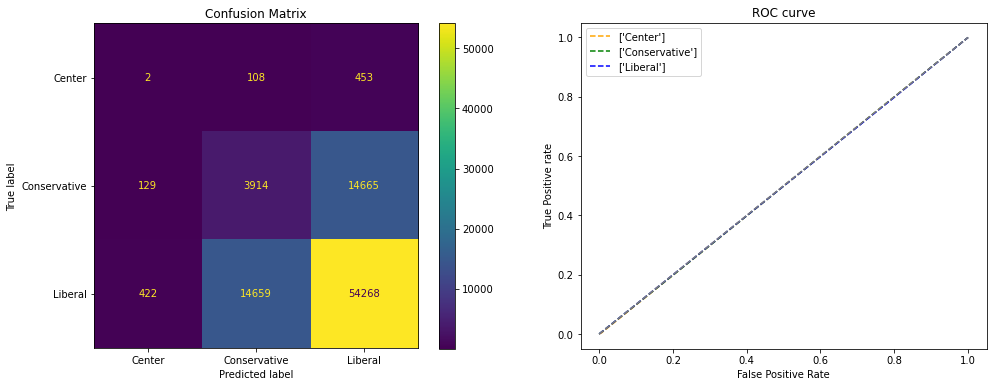

,model,cross_val,accuracy,precision,recall,f1,cohen-kappa,roc-auc
0,"(CountVectorizer(), DummyClassifier(random_sta...",0.65643,0.656556,0.331751,0.331767,0.331759,-0.001998,0.497517


In [9]:
#stratified dummy model as additional baseline 
dummy_pipe = make_pipeline(CountVectorizer(), DummyClassifier(random_state=42, strategy='stratified'))
dummy_pipe.fit(X_train, y_train_enc)

#evaluate model
model_evaluation(dummy_pipe, X_train, y_train_enc, X_test, y_test_enc, target_classes, score_tracker) 

### MultinomialNB with CountVectorizer

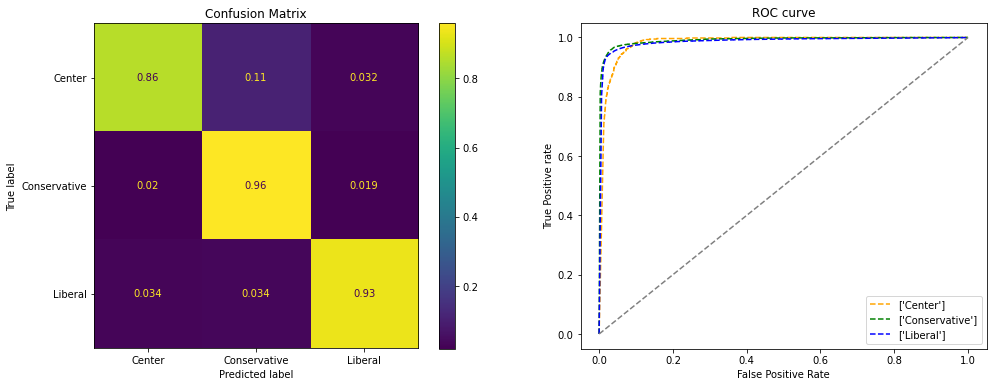

,model,cross_val,accuracy,precision,recall,f1,cohen-kappa,roc-auc
0,"(CountVectorizer(), MultinomialNB())",0.94079,0.937508,0.67526,0.917411,0.712577,0.834296,0.986204


In [11]:
#Create a MultinomialNB modeling pipeline with Count Vectorizer
ctvec_bayes_pipe = make_pipeline(CountVectorizer(),
                                 MultinomialNB())

#Fit model
ctvec_bayes_pipe.fit(X_train, y_train_enc)
                               
#Evaluate model
model_evaluation(ctvec_bayes_pipe, X_train, y_train_enc, X_test, y_test_enc, le.classes_, score_tracker)

**Evaluation**: The model accurately identifies the idology of emails ~93.8% of the time. It is most accurate with identifying conservative ideology, followed by liberal, and center. Next I will tune parameters with the aim of improving the model's F1 score

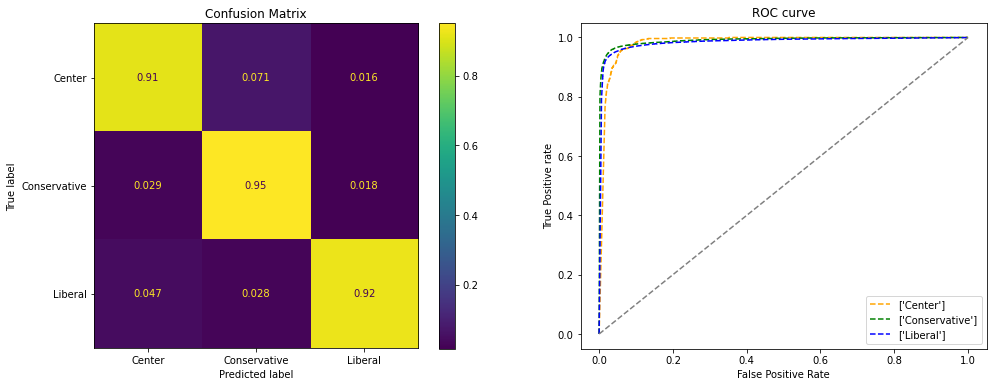

,model,cross_val,accuracy,precision,recall,f1,cohen-kappa,roc-auc
0,"(CountVectorizer(), MultinomialNB(alpha=0.5))",0.932721,0.93005,0.67042,0.9299,0.697396,0.817566,0.986177


In [12]:
#Tune alpha parameter
ctvec_bayes_pipe.set_params(multinomialnb__alpha=0.5) 

#fit model
ctvec_bayes_pipe.fit(X_train, y_train_enc) 

#Evaluate
model_evaluation(ctvec_bayes_pipe, X_train, y_train_enc, X_test, y_test_enc, le.classes_, score_tracker)

**Evaluation**: Tuning alpha to 0.5 decreased the overall accuracy score but improved classifying `center` targets, which was my initial goal. This model is most likely to confuse `center` as `conservative`. The accuracy of the `liberal` target also decreased with more `liberal` emails being classified as `center` than before.

I will conduct a GridSearch of parameters on the pipleine to find the `best_params_` that produce the highest accuracy score. Code guide for GridSearch in pipeline: [https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html)

In [74]:
#reset params of model
ctvec_bayes_pipe.set_params(multinomialnb__alpha=None)

#create param grid to search
param_grid = {'countvectorizer__min_df': [1, 2, 5, 50],
          'countvectorizer__max_features': [None, 1000, 2000],
          'multinomialnb__alpha': [0.75, 1]}


#gridsearch and pring best_param results
search = GridSearchCV(ctvec_bayes_pipe, param_grid=param_grid)
search.fit(X_train, y_train_enc)
print(search.best_params_)

{'countvectorizer__max_features': None, 'countvectorizer__min_df': 1, 'multinomialnb__alpha': 1}


### DecisionTree with Count Vectorizer

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,tree1,"(CountVectorizer(min_df=0.02), DecisionTreeCla...",0.941252,0.943049,0.943049,0.943049,0.943049,0.821123


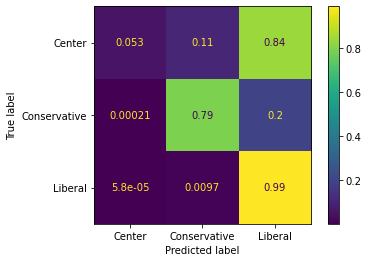

In [84]:
#Create a DecisionTree with CountVectorizer
tree_pipe = Pipeline([('vectorizer', CountVectorizer(min_df=0.02)),
                      ('tree', DecisionTreeClassifier(random_state=42, max_depth=10))])

#Fit to model
tree_pipe.fit(X_train, y_train_enc)

#Evaluate model
model_evaluation(tree_pipe, X_train, y_train_enc, X_test, y_test_enc, le.classes_)

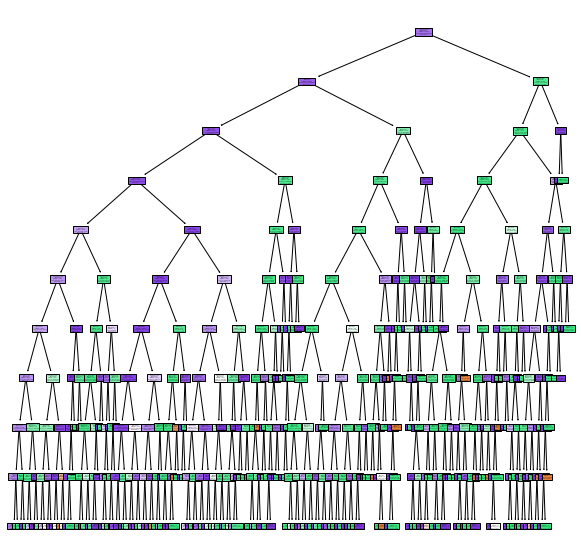

In [89]:
#Plot Tree
fig, axes = plt.subplots(figsize = (10, 10))

tree.plot_tree(tree_pipe['tree'], 
               feature_names = tree_pipe['vectorizer'].get_feature_names(), 
               class_names= target_classes, 
               filled = True)

plt.show();

In [98]:
#Finding the feature importances
features = dict(zip(tree_pipe['vectorizer'].get_feature_names(), tree_pipe['tree'].feature_importances_))

pd.DataFrame.from_dict(features, orient='index').sort_values(by=0, ascending=False).head(5)

,0
fewer,0.284083
privacy,0.126273
conservative,0.095600
actblue,0.058074
believe,0.047825


The first decison tree had an accuracy score of ~94%. It performed well in classifying `liberal` ideology of emails with 99% accuracy. It was less accurate when predicting `center`  and emails, they were only correctly predicted 5% of the time. Correctly predicting`conservative` emails with this decision tree were also less acurate than previous Naive Bayes models. 

A benifit of DecisionTrees is the ability to learn the feature importances the model used. The word 'privacy` was considered as the most important feature in this model. 

Moving forward in decision tree modeling, I will I will pass through a `class_weight` parameter with the goal of improving the accuracy of classifiying `center` and `conservative`

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,tree2,"(CountVectorizer(min_df=0.02), DecisionTreeCla...",0.791571,0.791627,0.791627,0.791627,0.791627,0.547441


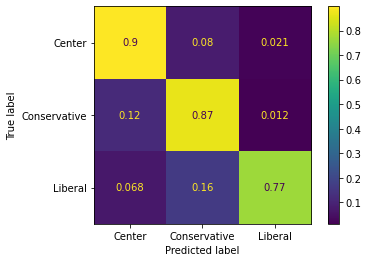

In [96]:
#tune parameters
tree_pipe.set_params(tree__class_weight ='balanced')

#fit
tree_pipe.fit(X_train, y_train_enc)

model_evaluation('tree2', tree_pipe, X_train, y_train_enc, X_test, y_test_enc)

Tuning the parameter `class_weights` to balanced had the desired effect of correctly predicting more `center` and `conservative` emails. This came at the cost of accuracy within the `liberal` and target. The accuracy score dropped to 79% which is only slightly better than our baseline (guessing) model. 

In [97]:
#Finding the feature importances
features = dict(zip(tree_pipe['vectorizer'].get_feature_names(), tree_pipe['tree'].feature_importances_))

pd.DataFrame.from_dict(features, orient='index').sort_values(by=0, ascending=False).head(5)

,0
fewer,0.284083
privacy,0.126273
conservative,0.095600
actblue,0.058074
believe,0.047825


'fewer' is considered the most important feature in this model, as compared to 'privacy' from the previous decision tree model. Interstinly, The top words in both cases are not intuative! In future modeling, I would like to include feature engineered variables into the decision tree. 

In the next phase of modling, I will tune the vectorizer rather than the decision tree. 

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,tree3,"(CountVectorizer(max_df=0.99, min_df=0.05), De...",0.95862,0.962469,0.962469,0.962469,0.962469,0.890453


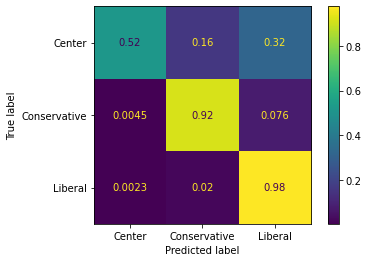

In [111]:
#remove tree parameters and adjust vectorizer
tree_pipe.set_params(tree__max_depth=None, tree__class_weight=None,
                     vectorizer__min_df=0.05, vectorizer__max_df=0.99)

#Fit
tree_pipe.fit(X_train, y_train_enc)

#Evaluate
model_evaluation('tree3', tree_pipe, X_train, y_train_enc, X_test, y_test_enc)

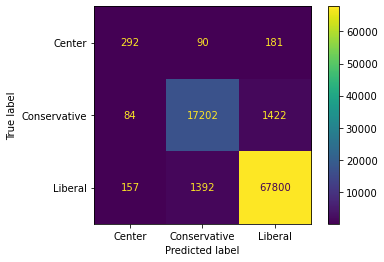

In [103]:
plot_confusion_matrix(tree_pipe, X_test, y_test_enc, display_labels=target_classes) #no normalizatoin

This tree is the most accurate so far with a 96% accuracy score. It improves from tree1 in in its `center` and `conservative` target predictions while only suffering 1% decrease accuracy of `liberal` email predictions. As with tree1 model the model was most likely to make an error by classifying `center` emails as `liberal`. 

When observing the nonnormalized confusion matrix, the class imabalnce becomes apparent as there are so few `center` emails compared to `liberal` emails. While 7% of conservative emails are mis-identified, compared to 32% of `center` emails, 7% of conservative emails represents a greater proportion of the corpus overall (1,422 emails compared to 181 emails). 

In [101]:
#Finding the feature importances
features = dict(zip(tree_pipe['vectorizer'].get_feature_names(), tree_pipe['tree'].feature_importances_))

pd.DataFrame.from_dict(features, orient='index').sort_values(by=0, ascending=False).head(5)

,0
privacy,0.265888
conservative,0.133553
liberal,0.056164
fewer,0.053462
paid,0.038439


### Stochastic Gradient Descent (SGD)

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,sgdc1,"(CountVectorizer(), SGDClassifier())",0.989316,0.990702,0.990702,0.990702,0.990702,0.972851


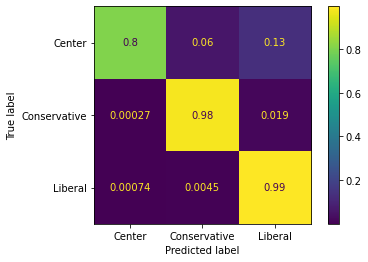

In [130]:
#Make SGDC pipline
sgdc_pipe = make_pipeline(CountVectorizer(),
                          SGDClassifier())

#Fit
sgdc_pipe.fit(X_train, y_train_enc)

#Evaluation
model_evaluation('sgdc1', sgdc_pipe, X_train, y_train_enc, X_test, y_test_enc)

In [132]:
#Finding the feature importances
features = sgdc_pipe['countvectorizer'].get_feature_names()
coefficients = sgdc_pipe['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

This model performed very well! With 99% accuracy! The model accurately classifyies both `liberal` and `conservative` emails, and captures a majority of the `center` ideology emails. The accuracy of each target corresponds with the proportion of the target within the dataset (liberal is the highest accuracy and the most observed label in the dataset, vice versa with center.) Perhaps the imbalance within the target partially contributes to the results. In the next model I will tune the class_weights of the SGDClassifier to 'balanced'.

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,sgdc2,"(CountVectorizer(), SGDClassifier(class_weight...",0.987678,0.988479,0.988479,0.988479,0.988479,0.966688


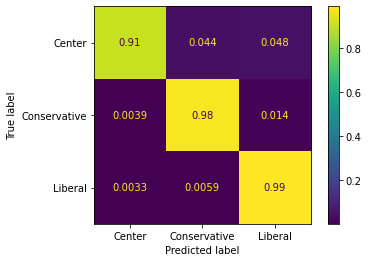

In [137]:
#Make SGDC2 pipline
sgdc_pipe = make_pipeline(CountVectorizer(),
                          SGDClassifier(class_weight='balanced',
                                        random_state=42))

#Fit
sgdc_pipe.fit(X_train, y_train_enc)

#Evaluation
model_evaluation('sgdc2', sgdc_pipe, X_train, y_train_enc, X_test, y_test_enc)

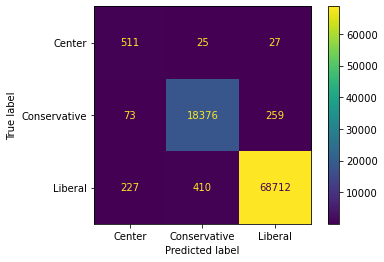

In [140]:
plot_confusion_matrix(sgdc_pipe, X_test, y_test_enc, display_labels=target_classes) #not normalized

In [138]:
#Finding the feature importances
features = sgdc_pipe['countvectorizer'].get_feature_names()
coefficients = sgdc_pipe['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

,features,values,abs_val
27167,garbarino,3.823415,3.823415
38435,labels,3.664436,3.664436
50707,palzewicz,3.535424,3.535424
39078,lawler,3.245631,3.245631
33733,independent,2.957484,2.957484
16238,cwa,2.842450,2.842450
46580,nan,-2.828916,2.828916
59304,rock,2.608237,2.608237
9374,byrne,2.599994,2.599994
75740,weber,2.522172,2.522172


So far, the SGDClassifier models are accurate on training and testing data. However, after inspecting the important features of the model many are names which may not be generalizeable to future classification situations and impact how this model performs on unseen data. 

##  SGDClassifier with binary variable
In this series of modeling, I am to explore if the features of a SGDClassifer model would be more generalizable using a binary target. I will train/test/split the data again after creating a binary target then model again with SGDClassifier and CountVectorizer.

In [19]:
#create new dataframe of only Liberal and Conservative emails
data2 = data.loc[data['target'] != "Center"].copy() 

#reproduce train/test/split with binary target
X2 = data2['text'].astype(str)
y2 = data2['target']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42, test_size=0.35, stratify=y2)
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_test2, y_test2, random_state=42, test_size = 0.2, stratify=y_test2)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc2= le.fit_transform(y_train2)
y_test_enc2= le.transform(y_test2)
y_val_enc2 = le.transform(y_val2)

target_classes = le.classes_ #keeping this as 'target_classes' for use in model_evaluation function

In [38]:
#Make SGDC pipline for binary target. Use same parameters as before
sgdc_binary = make_pipeline(CountVectorizer(),
                           SGDClassifier(random_state=42))

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('sgdclassifier', SGDClassifier(random_state=42))])

In [25]:
#Evaluation
y_preds = sgdc_binary.predict(X_test2)
sgdc_binary.score(X_test2, y_test_enc2)

0.9916417774850381

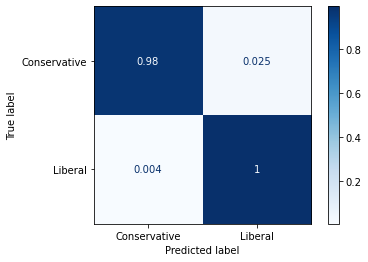

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(sgdc_binary, X_test2, y_test_enc2, normalize='true', cmap='Blues', display_labels=le.classes_)

In [33]:
#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

C:\Users\cryst\anaconda3\envs\email-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,values,abs_val
33048,inc,-1.128757,1.128757
10325,castle,-1.108382,1.108382
39233,liberal,-1.047258,1.047258
48731,opt,-0.982059,0.982059
22386,error,0.925010,0.925010
61704,shaun,-0.904636,0.904636
16932,deductible,0.900561,0.900561
46125,nbs,0.892411,0.892411
20837,edit,-0.892411,0.892411
45857,nan,0.888336,0.888336


The top features of this list are different from the multi-class target. It contains fewer names and more politically-charged words. 

In the next model I will tune the vectorizer to reduce the demensionality of the words. 

0.973324096891786


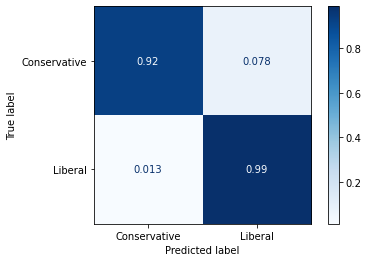

In [40]:
#Set parameter
sgdc_binary.set_params(countvectorizer__min_df=0.02, countvectorizer__max_df=0.99)

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
#model_evaluation('sgdc_binary2', sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2)
print (sgdc_binary.score(X_test2, y_test_enc2))

ConfusionMatrixDisplay.from_estimator(sgdc_binary, X_test2, y_test_enc2, normalize='true', cmap='Blues', display_labels=le.classes_)

In [41]:
#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

C:\Users\cryst\anaconda3\envs\email-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,values,abs_val
629,liberal,-1.782929,1.782929
282,deductible,1.565065,1.565065
9,actblue,1.505041,1.505041
796,patriot,-1.391663,1.391663
466,gifts,1.389439,1.389439
797,patriots,-1.349424,1.349424
772,opt,-1.313854,1.313854
168,charitable,-1.282730,1.282730
1033,socialist,-1.273838,1.273838
220,conservatives,-1.167129,1.167129


In [42]:
print(f'{len(feature_importances)} features in sgdc_binary2')

1266 features in sgdc_binary2


Reducing the number of features decreased the accuracy score from 99% to 97%. The model continues to perform well and better than the baseline. For the next model I will tune the CountVectorizer to allow for more features with the aim of increasing the accuracy score. 

0.9782754352294537


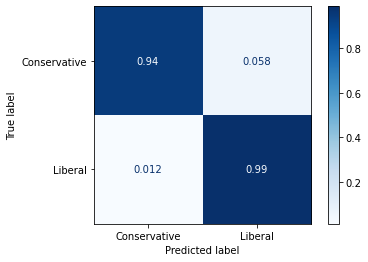

In [43]:
#adjust max_df parameter
sgdc_binary.set_params(countvectorizer__max_df=1.0, countvectorizer__min_df=0.01)

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
#model_evaluation('sgdc_binary3', sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2)
print(sgdc_binary.score(X_test2, y_test_enc2))
ConfusionMatrixDisplay.from_estimator(sgdc_binary, X_test2, y_test_enc2, normalize='true', cmap='Blues', display_labels=le.classes_)

In [44]:
#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

C:\Users\cryst\anaconda3\envs\email-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,values,abs_val
442,deductible,1.627311,1.627311
972,liberal,-1.573957,1.573957
1204,opt,-1.362762,1.362762
16,actblue,1.318300,1.318300
1242,patriots,-1.293846,1.293846
1593,socialist,-1.262723,1.262723
1241,patriot,-1.260499,1.260499
344,conservative,-1.220484,1.220484
257,charitable,-1.193806,1.193806
723,gifts,1.184914,1.184914


# FINAL WITH VAL

0.9791051555757438


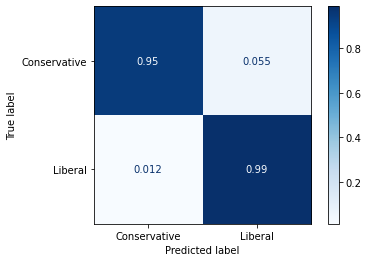

In [67]:
#adjust max_df parameter
sgdc_binary.set_params(countvectorizer__max_df=1.0, countvectorizer__min_df=0.01)

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
#model_evaluation('sgdc_binary3', sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2)
print(sgdc_binary.score(X_val2, y_val_enc2))
ConfusionMatrixDisplay.from_estimator(sgdc_binary, X_val2, y_val_enc2, normalize='true', cmap='Blues', display_labels=le.classes_)

In [68]:
#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

C:\Users\cryst\anaconda3\envs\email-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,values,abs_val
442,deductible,1.627311,1.627311
972,liberal,-1.573957,1.573957
1204,opt,-1.362762,1.362762
16,actblue,1.318300,1.318300
1242,patriots,-1.293846,1.293846
1593,socialist,-1.262723,1.262723
1241,patriot,-1.260499,1.260499
344,conservative,-1.220484,1.220484
257,charitable,-1.193806,1.193806
723,gifts,1.184914,1.184914


0.9743356802180332


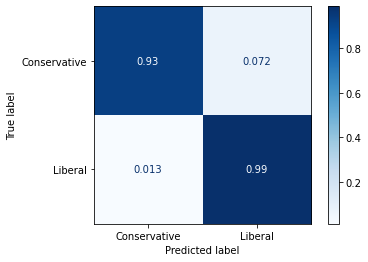

In [69]:
#Set parameter
sgdc_binary.set_params(countvectorizer__min_df=0.02, countvectorizer__max_df=0.99)

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
#model_evaluation('sgdc_binary2', sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2)
print (sgdc_binary.score(X_val2, y_val_enc2))

ConfusionMatrixDisplay.from_estimator(sgdc_binary, X_val2, y_val_enc2, normalize='true', cmap='Blues', display_labels=le.classes_)

In [70]:
#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

C:\Users\cryst\anaconda3\envs\email-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,values,abs_val
629,liberal,-1.782929,1.782929
282,deductible,1.565065,1.565065
9,actblue,1.505041,1.505041
796,patriot,-1.391663,1.391663
466,gifts,1.389439,1.389439
797,patriots,-1.349424,1.349424
772,opt,-1.313854,1.313854
168,charitable,-1.282730,1.282730
1033,socialist,-1.273838,1.273838
220,conservatives,-1.167129,1.167129


0.9743356802180332


C:\Users\cryst\anaconda3\envs\email-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,values,abs_val
530,liberal,-1.816275,1.816275
239,deductible,1.627311,1.627311
677,patriots,-1.507264,1.507264
9,actblue,1.493925,1.493925
392,gifts,1.420563,1.420563
658,opt,-1.264946,1.264946
306,error,1.249384,1.249384
189,conservatives,-1.164906,1.164906
469,inc,-1.153790,1.153790
144,charitable,-1.098213,1.098213


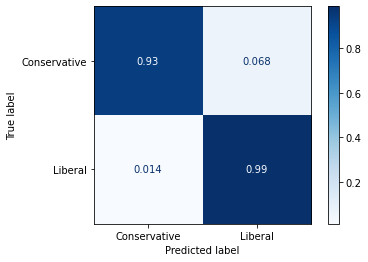

In [71]:
#Set parameter
sgdc_binary.set_params(countvectorizer__min_df=0.025, countvectorizer__max_df=1.0)

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
#model_evaluation('sgdc_binary2', sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2)
print (sgdc_binary.score(X_val2, y_val_enc2))

ConfusionMatrixDisplay.from_estimator(sgdc_binary, X_val2, y_val_enc2, normalize='true', cmap='Blues', display_labels=le.classes_)

#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

In [86]:
coefficients = sgdc_binary['sgdclassifier'].coef_

In [87]:
coefficients

array([[-0.05335447, -0.09337033,  0.12671687, ...,  0.10226274,
        -0.0755855 , -0.2200872 ]])

0.6619123325005678


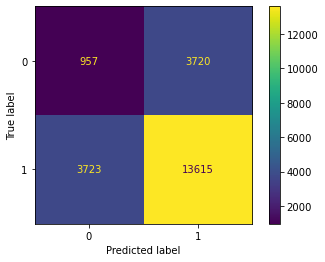

In [91]:
from sklearn.dummy import DummyClassifier

dummy_pipe = make_pipeline(CountVectorizer(), DummyClassifier(random_state=42, strategy='stratified'))

dummy_pipe.fit(X_train2, y_train_enc2)

print(dummy_pipe.score(X_val2, y_val_enc2))

ConfusionMatrixDisplay.from_estimator(dummy_pipe, X_val2, y_val_enc2)

In [94]:
accuracy_score(y_val_enc2, dummy_pipe.predict(X_val2))

0.6619123325005678

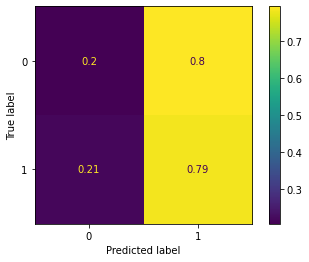

In [93]:
ConfusionMatrixDisplay.from_estimator(dummy_pipe, X_val2, y_val_enc2, normalize='true')

In [95]:
dummy_pipe.set_params(dummyclassifier__strategy='most frequent')
dummy_pipe.score(X_val2, y_val_enc2)

0.6619123325005678

In [96]:
recall_score(y_val_enc2, dummy_pipe.predict(X_val2))

0.7852693505594648

In [97]:
precision_score(y_val_enc2, dummy_pipe.predict(X_val2))

0.7854052494952408

In [98]:
X_test.head()

253553    trump hoover tenth dems newsletter may message...
191747    debate watch parties days go friend days left ...
213940    last time ask five times matched hey emailing ...
16903     cnn announced stop republicans proudly dedicat...
17154     trump freaking end citizens united dedicated e...
Name: text, dtype: object

In [99]:
f1_score(y_val_enc2, dummy_pipe.predict(X_val2))

0.7853372941481844